In [11]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [12]:
#import libs to resize and read files
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image

In [13]:
from pathlib import Path
import gc

In [14]:
#######################################
# List all files in the folder
#######################################
files = list(map(str, filter(lambda file: file.is_file(), Path("C:/temp/AR_out").rglob('*'))))

In [15]:
#######################################
#declare arrays
#######################################
image_resized_list = []
file_names_list = []


#######################################
# resize all files and save in arrays
#######################################
for file in files:
    # read image
    img = cv2.imread(file, cv2.IMREAD_UNCHANGED)

    # Set Scale
    scale_percent = 10 
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dimension = (width, height)

    # resize image
    resized = cv2.resize(img, dimension, interpolation = cv2.INTER_AREA)

    #save image resized and file name in arrays
    image_resized_list.append(resized)
    file_names_list.append(file.split('\\')[-1].split('.')[0])

In [16]:
##clear memory
gc.collect()

40

In [21]:
# Convert the list to a numpy array
image_resized_array = np.array(image_resized_list)
image_resized_array.shape

(3315, 57, 76, 3)

In [ ]:


# Get the number of images, dimensions and channels of each image
num_images, height, width, num_channels = image_resized_array.shape

# Reshape the array into a 2D array where each row is a vectorized image
data_2d = image_resized_array.reshape(num_images, -1)  # -1 is a placeholder that tells numpy to compute the size of this dimension

In [ ]:
mean_vector = np.mean(data_2d, axis=0)

In [ ]:
# Center the data by subtracting the mean
centered_data = data_2d - mean_vector

In [ ]:
covariance_matrix = np.dot(centered_data.T, centered_data) / (num_images - 1)

In [ ]:
covariance_matrix = np.cov(data_2d, rowvar=False)

import matplotlib.pyplot as plt
import seaborn as sns  # Optional, for better visualization

# Display a heatmap of the covariance matrix
plt.figure(figsize=(10, 10))
sns.heatmap(covariance_matrix, cmap='coolwarm', fmt='.2f')
plt.show()

In [ ]:
##clear memory
gc.collect()

In [ ]:
eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

In [ ]:
# Get the indices that would sort the eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]

# Sort the eigenvalues and eigenvectors
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]


In [ ]:
total_variance = np.sum(sorted_eigenvalues)

In [ ]:
cumulative_variance = np.cumsum(sorted_eigenvalues)

In [ ]:
num_eigenvectors_to_retain = np.argmax(cumulative_variance / total_variance >= 0.99) + 1
print (num_eigenvectors_to_retain)
#num_eigenvectors_to_retain = 500

In [ ]:
# Select the top eigenvectors to retain 99% of the variance
top_eigenvectors = sorted_eigenvectors[:, :num_eigenvectors_to_retain]


# Project the centered data onto the selected eigenvectors
projected_data = np.dot(centered_data, top_eigenvectors)

In [ ]:
# Project the centered data onto the selected eigenvectors
projected_data = np.dot(centered_data, top_eigenvectors)

In [ ]:
##############################################################################
#Making a test with a orignal, resized and projected image
##############################################################################
index = 2034  # Index of the image you want to select
source_image = cv2.imread(files[index], cv2.IMREAD_UNCHANGED) 
resized_image = image_resized_array[index]
original_image = image_resized_array[index]

In [ ]:
projected_representation = projected_data[index]
reconstructed_image_data = np.dot(projected_representation, top_eigenvectors.T)

In [ ]:
reconstructed_image = reconstructed_image_data.reshape(height, width, num_channels)
reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)


In [ ]:
plt.figure(figsize=(15, 5))  # Adjust the figure size to accommodate three images

# Display source image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
plt.imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB if necessary
plt.title('Source Image')

# Display original image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB if necessary
#axs[1].imshow(resized_image)
plt.title('resized Image')

# Display reconstructed image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB if necessary
plt.title('Vector Image remapped')

plt.show()

##### Merge projected_data with labels

In [26]:
import scr_deep_learning_cnn_keras_py as keras_ml
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
# Splitting each string by hyphen and storing the results in a new list
file_names_list = [name.split('-') for name in file_names_list]

# Creating a DataFrame from the list of split parts
file_names_list = pd.DataFrame(file_names_list, columns=['gender', 'seq', 'type'])

In [28]:
file_names_list

,gender,seq,type
0,m,001,1
1,m,001,10
2,m,001,11
3,m,001,12
4,m,001,13
...,...,...,...
3310,w,060,5
3311,w,060,6
3312,w,060,7
3313,w,060,8


In [29]:
#Replace genre man and woman to 0 and 1
file_names_list['gender'] = file_names_list['gender'].replace('m', 0)
file_names_list['gender'] = file_names_list['gender'].replace('w', 1)

In [30]:
#Replace from string to int
file_names_list['gender'] = file_names_list['gender'].astype(int)
file_names_list['seq'] = file_names_list['seq'].astype(int)
file_names_list['type'] = file_names_list['type'].astype(int)

In [33]:
image_resized_array = pd.DataFrame(image_resized_array)


ValueError: Must pass 2-d input. shape=(3315, 57, 76, 3)

In [ ]:
##clear memory
gc.collect()

In [ ]:
print(projected_data.shape)
print(file_names_list.shape)

In [ ]:
projected_data = pd.concat([projected_data, file_names_list], axis=1)


In [31]:
image_resized_array = pd.concat([image_resized_array, file_names_list], axis=1)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [ ]:
projected_data.shape

In [ ]:
projected_data.head(10)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(projected_data.iloc[:, :748].values, projected_data.iloc[:, 749].values, test_size=0.3, random_state=0)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
# DEBUG. Plot some of the images
plt.figure(figsize=(18, 9))

num_rows = 4
num_cols = 748

# plot each of the images in the batch and the associated ground truth labels.
for i in range(num_rows*num_cols):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_train[i,:,:])
    ax.title.set_text(y_train[i,0])
    plt.axis("off")

In [ ]:

# Normalize images to the range [0, 1].
X_train = X_train.astype("float32") / 255
X_test  = X_test.astype("float32") / 255

# Change the labels from integer to categorical data.
print('Original (integer) label for the first training sample: ', y_train[0])

# Convert labels to one-hot encoding.
y_train = keras_ml.to_categorical(y_train)
y_test  = keras_ml.to_categorical(y_test)

print('After conversion to categorical one-hot encoded labels: ', y_train[0])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential([
    Dense(128, activation='relu', input_shape=(748,)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Single neuron for binary classification
])

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  # Using binary_crossentropy for binary classification
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    verbose=1,
                    validation_split=0.3)

In [ ]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

keras_ml.plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

keras_ml.plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [ ]:
from tensorflow.keras.optimizers import Adam
learning_rate = 0.0000000001  # This is a commonly used starting point, but you may need to adjust it


In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(748,)),
    Dropout(0.5),  # Adding dropout
    Dense(64, activation='relu'),
    Dropout(0.5),  # Adding dropout
    Dense(1, activation='sigmoid')
])

In [ ]:
# Using Adam optimizer with a custom learning rate
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Early stopping

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100,  # Increased epochs
                    verbose=1, validation_split=0.3, shuffle=True,  # Added shuffle
                    callbacks=[early_stopping])  # Added early stopping

In [ ]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

keras_ml.plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

keras_ml.plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [22]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass


In [23]:
# Load the dataset (CIFAR-10)
(X_train, y_train), (X_test, y_test) = keras_ml.cifar10.load_data()


In [24]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
y_train.shape

In [ ]:

print('Learning set:')
print('X: ', end='')
print(X_train.shape)
print('y: ', end='')
print(y_train.shape)

print('Test set:')
print('X: ', end='')
print(X_test.shape)
print('y: ', end='')
print(y_test.shape)

# DEBUG. Plot some of the images
plt.figure(figsize=(18, 9))

num_rows = 4
num_cols = 5

# plot each of the images in the batch and the associated ground truth labels.
for i in range(num_rows*num_cols):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_train[i,:,:])
    ax.title.set_text(y_train[i,0])
    plt.axis("off")

# Normalize images to the range [0, 1].
X_train = X_train.astype("float32") / 255
X_test  = X_test.astype("float32") / 255

# Change the labels from integer to categorical data.
print('Original (integer) label for the first training sample: ', y_train[0])

# Convert labels to one-hot encoding.
y_train = keras_ml.to_categorical(y_train)
y_test  = keras_ml.to_categorical(y_test)

print('After conversion to categorical one-hot encoded labels: ', y_train[0])


In [ ]:

# Create the model.
model = keras_ml.cnn_model()
model.summary()

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
             )

history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    verbose=1,
                    validation_split=.3,
                   )


# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

keras_ml.plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

keras_ml.plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [ ]:
############################################
#3th attempt   #############################
############################################

In [ ]:
file_names_list = file_names_list.values

In [36]:
file_names_list

array([[ 0,  1,  1],
       [ 0,  1, 10],
       [ 0,  1, 11],
       ...,
       [ 1, 60,  7],
       [ 1, 60,  8],
       [ 1, 60,  9]])

In [ ]:
image_resized_array = np.concatenate((image_resized_array, file_names_list))

In [38]:
print(image_resized_array.shape)
print(file_names_list.shape)

(3315, 57, 76, 3)
(3315, 3)


In [45]:
file_names_list[:, 0]

array([0, 0, 0, ..., 1, 1, 1])

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_resized_array, file_names_list[:, 0], test_size=0.3, random_state=0)

Learning set:
X: (2320, 57, 76, 3)
y: (2320,)
Test set:
X: (995, 57, 76, 3)
y: (995,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

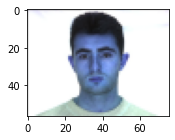

In [49]:


def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, 9])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()


def cnn_model(input_shape=(57, 76, 3)):

    model = Sequential()

    #------------------------------------
    # Conv Block 1: 32 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=57, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=57, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Conv Block 2: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Conv Block 3: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model

# ##########################################################################

# Load the dataset (CIFAR-10)
#(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Learning set:')
print('X: ', end='')
print(X_train.shape)
print('y: ', end='')
print(y_train.shape)

print('Test set:')
print('X: ', end='')
print(X_test.shape)
print('y: ', end='')
print(y_test.shape)

# DEBUG. Plot some of the images
plt.figure(figsize=(18, 9))

num_rows = 4
num_cols = 5

# plot each of the images in the batch and the associated ground truth labels.
for i in range(num_rows*num_cols):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_train[i,:,:])
    ax.title.set_text(y_train[i,0])
    plt.axis("off")

# Normalize images to the range [0, 1].
X_train = X_train.astype("float32") / 255
X_test  = X_test.astype("float32") / 255

# Change the labels from integer to categorical data.
print('Original (integer) label for the first training sample: ', y_train[0])

# Convert labels to one-hot encoding.
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

print('After conversion to categorical one-hot encoded labels: ', y_train[0])

# Create the model.
model = cnn_model()
model.summary()

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
             )

history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    verbose=1,
                    validation_split=.3,
                   )


# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [ ]:
#Build a Gender model

In [ ]:
#Build a Glasses

In [ ]:
#Build a ID model


In [ ]:
#Build a Facial expression